This notebook will be used to create the plots that will do daily comparisons of the model to ONC VENUS nodes.

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd
import seaborn as sns
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze, figures)

%matplotlib inline

In [2]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color': 'white'}

What day do we want to look at?
    * The time must be 00:45:00 because that is when the second available value for any day. The first time available is at 00:15:00 but in python the matlab time translate to a value with alot of decimals.

In [3]:
yesterday = datetime.datetime(2015, 8, 3, 0, 45, 0)
yesterdate = yesterday.strftime('%d%b%y').lower()

##Load the grids
* Model values

In [4]:
filC='/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_central_gridded.nc'.format(yesterdate)
filE='/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_east_gridded.nc'.format(yesterdate)
filet=glob.glob('/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/SalishSea_1h_*_grid_T.nc'.format(yesterdate))[0]

grid_c = nc.Dataset(filC)
grid_e = nc.Dataset(filE)
grid_t= nc.Dataset(filet)

* Observational values

In [5]:
grid_oc = sio.loadmat('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Nodes/ADCPcentral.mat')
grid_oe = sio.loadmat('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Nodes/ADCPeast.mat')

#Prepare velocities

In [6]:
def load_vel(day, grid, source, deprange):
    """Prepares the model and observational velocities for plotting by unstaggering, masking and selecting the depths. 
    :arg day: The day
    :type day: datetime object
    
    :arg grid: quarter-hourly results of the model at the VENUS nodes or half-hourly results of the VENUS ADCP values
    :type grid: dictionary or netCDF dataset
    
    :arg source: sets whether it is model values or observational values. 'model' or 'observations'
    :type source: string
    
    :arg deprange: the range of depths that will be looked at in meters. (ex. [min, max])
    :type deprange: list
    """
    if source == 'model':
        #Set up model nowcast variables
        dep = grid.variables['depthv']  
        jm = np.where(np.logical_and(dep[:] > deprange[0], dep[:] < deprange[1]))
        dep = dep[jm[0]] 

        u_u = grid.variables['vozocrtx'][:,jm[0],:]
        v_v = grid.variables['vomecrty'][:,jm[0],:]
        u_E, v_N = research_VENUS.unstag_rot(u_u, v_v)
        u_0 = u_E[..., 0, 0]
        v_0 = v_N[..., 0, 0]    
        u = np.ma.masked_values(u_0, 0)
        v = np.ma.masked_values(v_0, 0)
        
        
    else:
        timemat = grid['mtime']
        
        #Find index in matlab datenum values that corresponds with the day of interest.
        for mattime, count in zip(timemat[0], np.arange(len(timemat[0]))):
            time = datetime.datetime.fromordinal(int(mattime)) + datetime.timedelta(days=mattime%1) - datetime.timedelta(days = 366)
            if time == day:
                thetime = time
                # The -1 is because we access the 00:45:00 index which is the second value of the day.
                ind = count-1
                
        # The obs values are every half hour. We need the 48 next values to have the whole day.        
        oneday = 48       
        dep = grid['chartdepth'][:][0]
        j = np.where(np.logical_and(dep[:] > deprange[0], dep[:] < deprange[1]))
        dep = dep[j[0]]
        #The velocities are in cm/s we want them in m/s. 
        u0 = grid['utrue'][:][j[0], ind:ind+oneday]/100
        v0 = grid['vtrue'][:][j[0], ind:ind+oneday]/100
        
        u = np.ma.masked_invalid(u0)
        v = np.ma.masked_invalid(v0)
        

    return u, v, dep


##Contour plot of velocities

In [7]:
def plotADCP(grid_m, grid_o, day, station, profile):
    """ This function will plots the velocities on a colour map with depth of the model and observational 
    data over a whole day at a particular station.
    
    :arg grid_m: The model grid
    :type grid_m: neCDF4 dataset.
    
    :arg grid_o: The observational grid
    :type grid_o: dictionary
    
    :arg day: day of interest
    :type day: datetime object
    
    :arg station: Station of interest. Either 'Central' or 'East'.
    :type station: string
    
    :arg profile: the range of depths that will be looked at in meters. (ex. [min, max])
    :type profile: list
    
    :return: fig
    """
    
    #Get grids into unstaggered and masked velocities at the chose depths
    u_E, v_N, dep_t = load_vel(day, grid_m, 'model', profile)
    u, v, dep = load_vel(day, grid_o, 'observation', profile)
    
    
    #Begin figure
    fig, ([axmu, axmv], [axou, axov]) = plt.subplots(2, 2, figsize=(20,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    #Find the absolute maximum value between the model and observational velocities to set the colorbar
    max_v = np.nanmax(abs(v))
    max_u = np.nanmax(abs(u))
    max_vm = np.nanmax(abs(v_N))
    max_um = np.nanmax(abs(u_E))
    max_speed = np.amax([max_v, max_u, max_vm, max_um])
    vmax = max_speed
    vmin = - max_speed
    step = 0.05

    cmap = plt.get_cmap('jet')
    dep_s = research_VENUS.SITES['VENUS'][station]['depth']
    
    #Setting the date for title
    date = day.strftime('%d%b%y')
    
    #Plotting the comparison between the model velocities and the observational velocities
    increment = [0.25, 0.5, 0.25, 0.5]
    velocities = [u_E.transpose(), u, v_N.transpose(), v]
    axes = [axmu, axmv,axou, axov]
    depths = [dep_t, dep, dep_t, dep]
    names = ['Model', 'Observations', 'Model', 'Observations']
    direction = ['East/West', 'East/West', 'North/South', 'North/South']
    
    for ax, vel, timestep, depth, name, direc in zip(axes, velocities, increment, depths, names, direction):
        ax.invert_yaxis()
        mesh = ax.contourf(
            #The range below adjusts for the observations starting at 00:15 and being in 30 minutes increments.
            np.arange(timestep-0.25, 24+timestep-0.25, timestep),
            depth[:],
            vel,
            np.arange(vmin, vmax, step), cmap=cmap)
        ax.set_ylim([profile[1], profile[0]])
        ax.set_xlim([0.25, 23])
        ax.set_ylabel('Depth [m]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('{dire} {name} Velocities at VENUS {node} on {date}'.format(
            dire=direc, name = name, node=station, date=date), **title_font)

    cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')    
    cbar.set_label('[m/s]', **axis_font)

    return fig

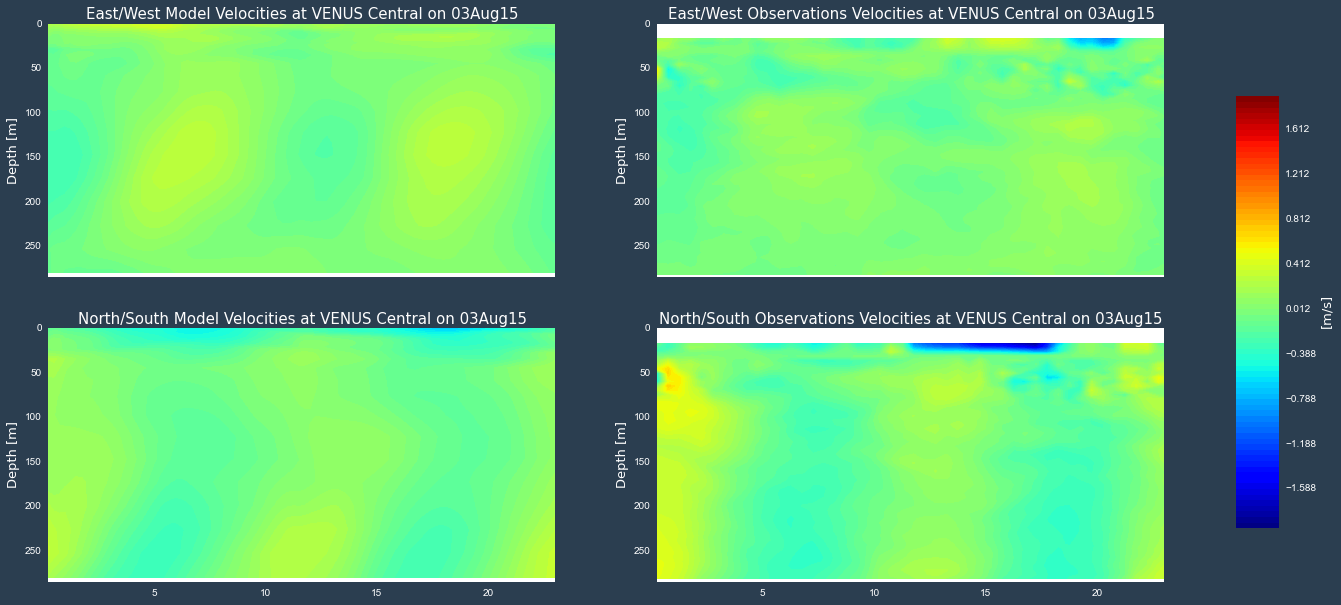

In [8]:
fig1 = plotADCP(grid_c, grid_oc, yesterday, 'Central', [0,285])

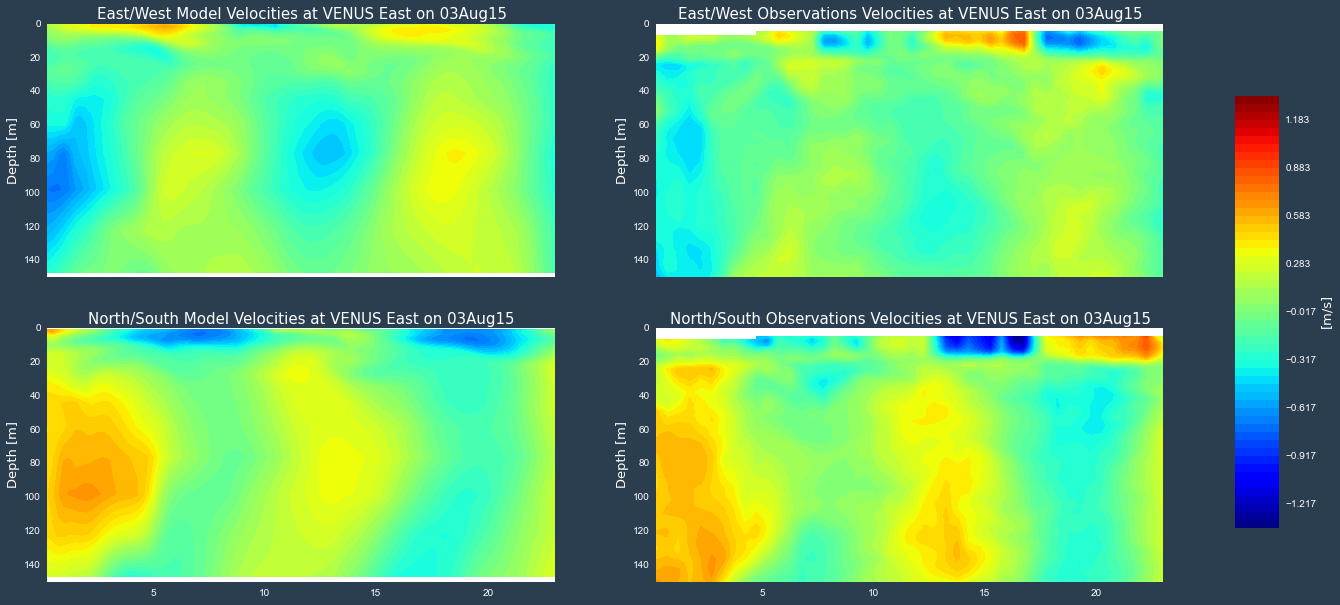

In [9]:
fig1 = plotADCP(grid_e, grid_oe, yesterday, 'East', [0,150])

##Depth averaged velcities

In [10]:
def plotdepavADCP(grid_m, grid_o, day, station):
    """ This function plots a comparison of the depth averaged velocities of the model and the observations.
    
    :arg grid_m: The model grid
    :type grid_m: neCDF4 dataset.
    
    :arg grid_o: The observational grid
    :type grid_o: dictionary
    
    :arg day: day of interest
    :type day: datetime object
    
    :arg station: Station of interest. Either 'Central' or 'East'.
    :type station: string
    
    :return: fig
    """
    if station =='Central':
        profile = [40, 250]
    else:
        profile = [30, 150]
        
    #Get grids into unstaggered and masked velocities at the chose depths
    u_E, v_N, dep_t = load_vel(day, grid_m, 'model', profile)
    u, v, dep = load_vel(day, grid_o, 'observation', profile)


    #Depth averaging center of water column
    uE_av = analyze.depth_average(u_E,dep_t,1)
    vN_av = analyze.depth_average(v_N,dep_t,1)
    u_av = analyze.depth_average(u,dep[::-1],0)
    v_av = analyze.depth_average(v,dep[::-1],0)

    #Begin figure
    fig, ([ax1, ax2]) = plt.subplots(2, 1, figsize=(15,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    #Setting the date for title
    date = day.strftime('%d%b%y')
    
    timestep = 0.5
    velocities = [uE_av, vN_av]
    veloobs = [u_av, v_av]
    axes = [ax1, ax2]
    direction = ['East/West', 'North/South',]
    
    for ax, vel, velo, direc in zip(axes, velocities, veloobs, direction):
        ax.plot(np.arange(0, 24, timestep/2), vel, label = 'Model')
        ax.plot(np.arange(0.25, 24, timestep), velo, label = 'Observations')
        ax.set_xlim([0, 24])
        ax.set_ylabel('Velocity [m/s]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('Depth Averaged ({}-{}m) {dire} velocities at VENUS {node} on {date}'.format(
            profile[0], profile[1], dire=direc, node=station, date=date), **title_font)
    ax1.legend(loc=0)

    return fig

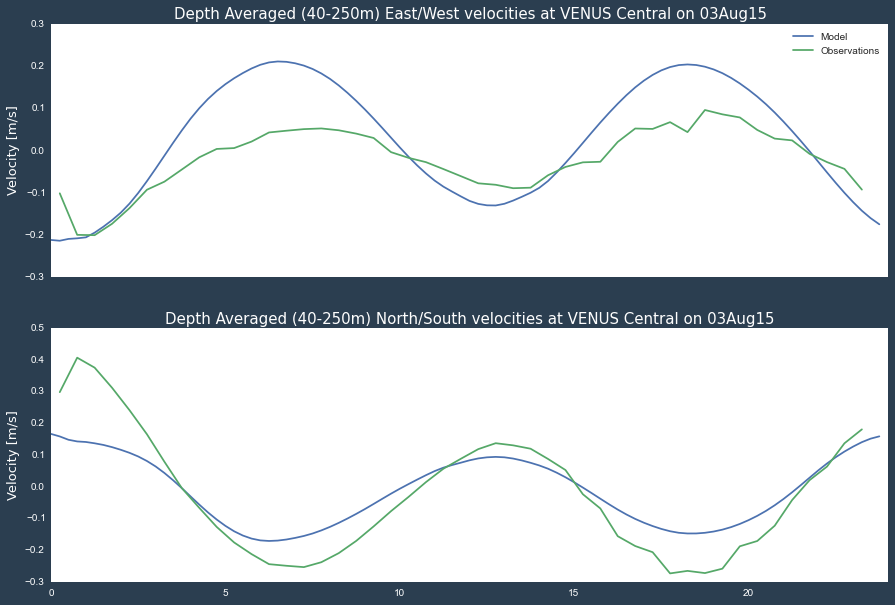

In [11]:
fig = plotdepavADCP(grid_c, grid_oc, yesterday, 'Central')

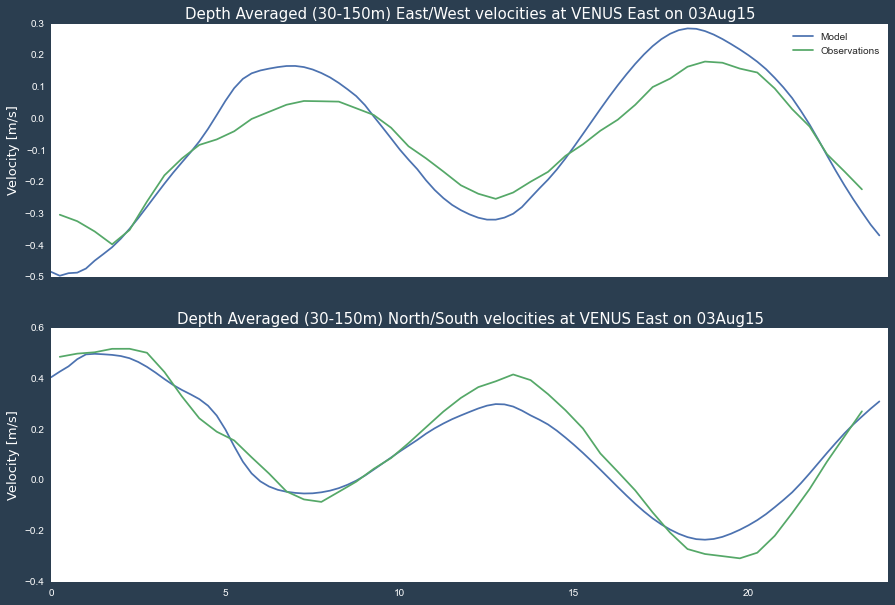

In [12]:
fig = plotdepavADCP(grid_e, grid_oe, yesterday, 'East')

##Time averaged velocities

In [13]:
def plottimeavADCP(grid_m, grid_o, day, station):
    """ This function plots a comparison of the time averaged velocities of the model and the observations.
    
    :arg grid_m: The model grid
    :type grid_m: neCDF4 dataset.
    
    :arg grid_o: The observational grid
    :type grid_o: dictionary
    
    :arg day: day of interest
    :type day: datetime object
    
    :arg station: Station of interest. Either 'Central' or 'East'.
    :type station: string
    
    :return: fig
    """
    
    if station =='Central':
        profile = [0, 300]
    else:
        profile = [0, 170]
    
    #Get grids into unstaggered and masked velocities at the chose depths
    u_E, v_N, dep_t = load_vel(day, grid_m, 'model', profile)
    u, v, dep = load_vel(day, grid_o, 'observation', profile)

    #Begin figure
    fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(10,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    #Setting the date for title
    date = day.strftime('%d%b%y')
    
    velocities = [u_E, v_N]
    veloobs = [u, v]
    axes = [ax1, ax2]
    direction = ['E/W', 'N/S',]
    
    for ax, vel, velo, direc in zip(axes, velocities, veloobs, direction):
        ax.invert_yaxis()
        ax.plot(np.nanmean(vel, axis=0),dep_t[:],  label = 'Model')
        ax.plot(np.nanmean(velo, axis=1), dep,label = 'Observations')
        ax.set_ylabel('Velocity [m/s]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('{dire} velocities at VENUS {node}'.format(
            dire=direc, node=station, date=date), **title_font)
    ax1.legend(loc=0)

    return fig

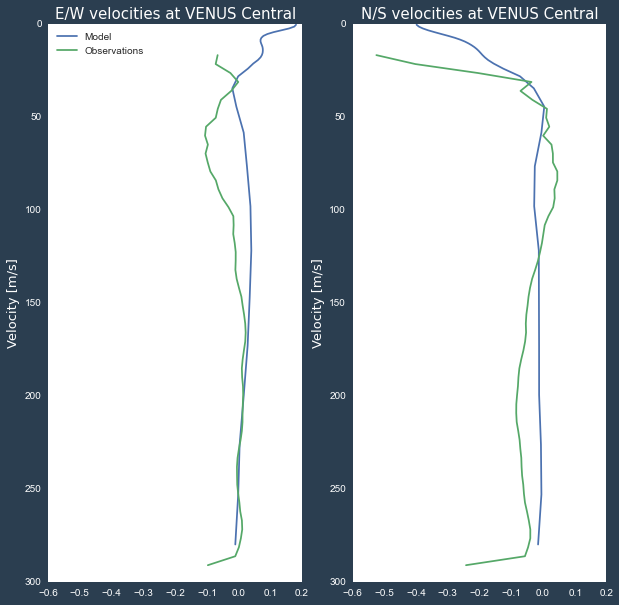

In [14]:
fig = plottimeavADCP(grid_c, grid_oc, yesterday, 'Central')

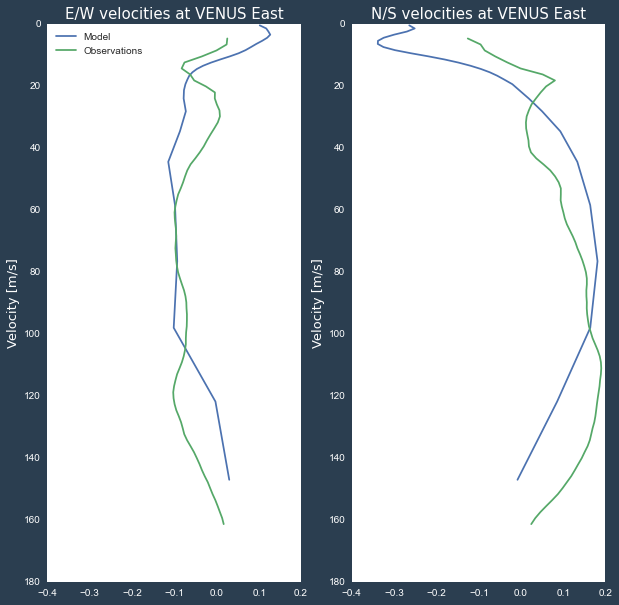

In [15]:
fig = plottimeavADCP(grid_e, grid_oe, yesterday, 'East')